# Safety Metric

In [1]:
import math
import pandas as pd
%matplotlib inline

### Designing the Metric
We believe safety is an important part of deciding the best neighborhood in Pittsburgh. If the neighborhood is safe, it will be more appealing to people looking to move there. Residents will also participate in more neighborhood events and visit commercial districts more. 

To create a safety metric, we will first read in a dataset for arrests in Pittsburgh Neighborhoods, using the head() function to get a look at what we are working with.

In [2]:
crime = pd.read_csv("CrimeData.csv", parse_dates = True)
crime.groupby("INCIDENTNEIGHBORHOOD")
crime.head(10)

,PK,CCR,AGE,GENDER,RACE,ARRESTTIME,ARRESTLOCATION,OFFENSES,INCIDENTLOCATION,INCIDENTNEIGHBORHOOD,INCIDENTZONE,INCIDENTTRACT,COUNCIL_DISTRICT,PUBLIC_WORKS_DIVISION,X,Y
0,1975272,16158872,42.0,F,B,2016-08-24T12:20:00,"4700 Block Centre AV Pittsburgh, PA 15213",3929 Retail Theft.,"4700 Block Centre AV Pittsburgh, PA 15213",Bloomfield,5,804.0,8.0,2.0,-79.949277,40.452551
1,1974456,16144120,31.0,M,W,2016-08-03T14:55:00,"4200 Block Steubenville PKE Pittsburgh, PA 15205",13(a)(16) Possession of Controlled Substance,"4200 Block Steubenville PKE Pittsburgh, PA 15205",Outside City,OSC,5599.0,NaN,NaN,-80.088018,40.440136
2,1974466,16144165,63.0,F,B,2016-08-03T16:45:00,"900 Block Freeport RD Fox Chapel, PA 15238",3929 Retail Theft.,"900 Block Freeport RD Fox Chapel, PA 15238",Westwood,5,2811.0,9.0,2.0,-79.891803,40.486625
3,1974550,16145257,25.0,F,W,2016-08-05T02:36:00,"Foreland ST & Cedar AV Pittsburgh, PA 15212",5503 Disorderly Conduct. / 5505 Public Drunken...,"Foreland ST & Cedar AV Pittsburgh, PA 15212",East Allegheny,1,2304.0,1.0,1.0,-80.001939,40.454080
4,1974596,16145962,25.0,M,B,2016-08-06T02:00:00,"900 Block Woodlow ST Pittsburgh, PA 15205",2702 Aggravated Assault. / 2705 Recklessy Enda...,"900 Block Woodlow ST Pittsburgh, PA 15205",Crafton Heights,5,2814.0,2.0,5.0,-80.052204,40.445900
5,1974556,16144301,45.0,M,W,2016-08-15T13:30:00,"600 Block 1st AV Pittsburgh, PA 15219",3929 Retail Theft.,"800 Block Hazelwood AV Pittsburgh, PA 15217",Greenfield,4,1517.0,5.0,3.0,-79.929238,40.419699
6,1974628,16147655,29.0,M,W,2016-08-16T13:00:00,"2300 Block Pioneer AV Pittsburgh, PA 15226",2701 Simple Assault.,"2300 Block Pioneer AV Pittsburgh, PA 15226",Brookline,6,1919.0,4.0,5.0,-80.020357,40.400037
7,1974607,16146037,21.0,F,B,2016-08-16T04:25:00,"600 Block 1st AV Pittsburgh, PA 15219",2701 Simple Assault. / 5505 Public Drunkenness...,"700 Block S Braddock AV Pittsburgh, PA 15221",Regent Square,4,1410.0,NaN,NaN,-79.834462,40.398957
8,1974643,16132537,17.0,M,B,2016-08-29T17:55:00,"1400 Block Washington BL Pittsburgh, PA 15206",903 Criminal Conspiracy. / 3701 Robbery.,"N Euclid AV & Broad ST Pittsburgh, PA 15206",East Liberty,5,1115.0,NaN,NaN,0.000000,0.000000
9,1974647,16138646,14.0,M,B,2016-08-23T13:36:00,Zone 2,3127 Indecent Exposure. / 3123(a)(6) IDSI with...,Zone 5,NaN,5,NaN,NaN,NaN,NaN,NaN


The "offenses" column gives a small summary of the crime that occured. We can use this to make our safety metric more accurate, assigning more weight to violent crime than petty crime. 

### Working with the Data

Firstly, we'll cut out all the unnecessary data columns, keeping the "offenses" and "incident_neighborhood" columns. We will also keep the CCR column so we can check for duplicates later.

In [3]:
crime = crime[['CCR', 'OFFENSES', 'INCIDENTNEIGHBORHOOD']]
crime.head(10)

,CCR,OFFENSES,INCIDENTNEIGHBORHOOD
0,16158872,3929 Retail Theft.,Bloomfield
1,16144120,13(a)(16) Possession of Controlled Substance,Outside City
2,16144165,3929 Retail Theft.,Westwood
3,16145257,5503 Disorderly Conduct. / 5505 Public Drunken...,East Allegheny
4,16145962,2702 Aggravated Assault. / 2705 Recklessy Enda...,Crafton Heights
5,16144301,3929 Retail Theft.,Greenfield
6,16147655,2701 Simple Assault.,Brookline
7,16146037,2701 Simple Assault. / 5505 Public Drunkenness...,Regent Square
8,16132537,903 Criminal Conspiracy. / 3701 Robbery.,East Liberty
9,16138646,3127 Indecent Exposure. / 3123(a)(6) IDSI with...,NaN


Much better. Now we can split the data into two categories: violent and non-violent. We will do so by going through the dataset and eyeing all the keywords used to describe violent crime. Then we can create the non-violent dataset by exclusion. 

First, the violent crime.

In [4]:
violent_crime = crime[crime['OFFENSES'].str.contains('|'.join(["Assault", "Homicide", "Robbery", "IDSI", "Death", "Injury"]), na=False)]
violent_crime.head(10)

,CCR,OFFENSES,INCIDENTNEIGHBORHOOD
4,16145962,2702 Aggravated Assault. / 2705 Recklessy Enda...,Crafton Heights
6,16147655,2701 Simple Assault.,Brookline
7,16146037,2701 Simple Assault. / 5505 Public Drunkenness...,Regent Square
8,16132537,903 Criminal Conspiracy. / 3701 Robbery.,East Liberty
9,16138646,3127 Indecent Exposure. / 3123(a)(6) IDSI with...,NaN
10,16149661,2701 Simple Assault. / 3304 Criminal Mischief....,East Hills
11,16146903,2701 Simple Assault.,Carrick
15,16156591,903 Criminal Conspiracy. / 3701 Robbery.,Allegheny Center
20,16150804,2701 Simple Assault.,South Side Flats
21,16157283,903 Criminal Conspiracy. / 2701 Simple Assault...,East Carnegie


Then, the non violent crime.

In [5]:
non_violent_crime = crime[~crime['CCR'].isin(violent_crime['CCR'])]
non_violent_crime.head(10)

,CCR,OFFENSES,INCIDENTNEIGHBORHOOD
0,16158872,3929 Retail Theft.,Bloomfield
1,16144120,13(a)(16) Possession of Controlled Substance,Outside City
2,16144165,3929 Retail Theft.,Westwood
3,16145257,5503 Disorderly Conduct. / 5505 Public Drunken...,East Allegheny
5,16144301,3929 Retail Theft.,Greenfield
12,16153543,5507 Obstructing Highways and Passages.,East Allegheny
13,16144432,3921(a) Theft by Unlawful Taking or Dispositio...,Crafton Heights
14,16157821,5123 Contraband. / 13(a)(16) Possession of Con...,East Allegheny
16,16160913,5505 Public Drunkenness / 13(a)(32) Parapherna...,East Allegheny
17,16160953,6106 Firearms not to be Carried without a Lice...,South Side Flats


### Getting Scores

Now that we've categorized the data, we can get a count for the neighborhoods.

In [6]:
violent_crime = violent_crime['INCIDENTNEIGHBORHOOD'].value_counts(dropna=True).rename_axis('INCIDENTNEIGHBORHOOD').reset_index(name='count')

violent_crime.head(10)

,INCIDENTNEIGHBORHOOD,count
0,South Side Flats,599
1,Central Business District,590
2,Carrick,567
3,Marshall-Shadeland,437
4,Homewood North,400
5,Sheraden,375
6,Beechview,370
7,East Hills,353
8,Brookline,352
9,Mount Washington,349


In [7]:
non_violent_crime = non_violent_crime['INCIDENTNEIGHBORHOOD'].value_counts(dropna=True).rename_axis('INCIDENTNEIGHBORHOOD').reset_index(name='count')

non_violent_crime.head(10)

,INCIDENTNEIGHBORHOOD,count
0,Central Business District,2233
1,South Side Flats,1758
2,East Allegheny,1379
3,Homewood South,1181
4,Carrick,1089
5,Homewood North,974
6,East Liberty,965
7,Bluff,887
8,Allegheny Center,717
9,Mount Washington,663


Now, we can get a weighted score by combining the counts with a 2x multiplier for violent crime.

<AxesSubplot:xlabel='INCIDENTNEIGHBORHOOD'>

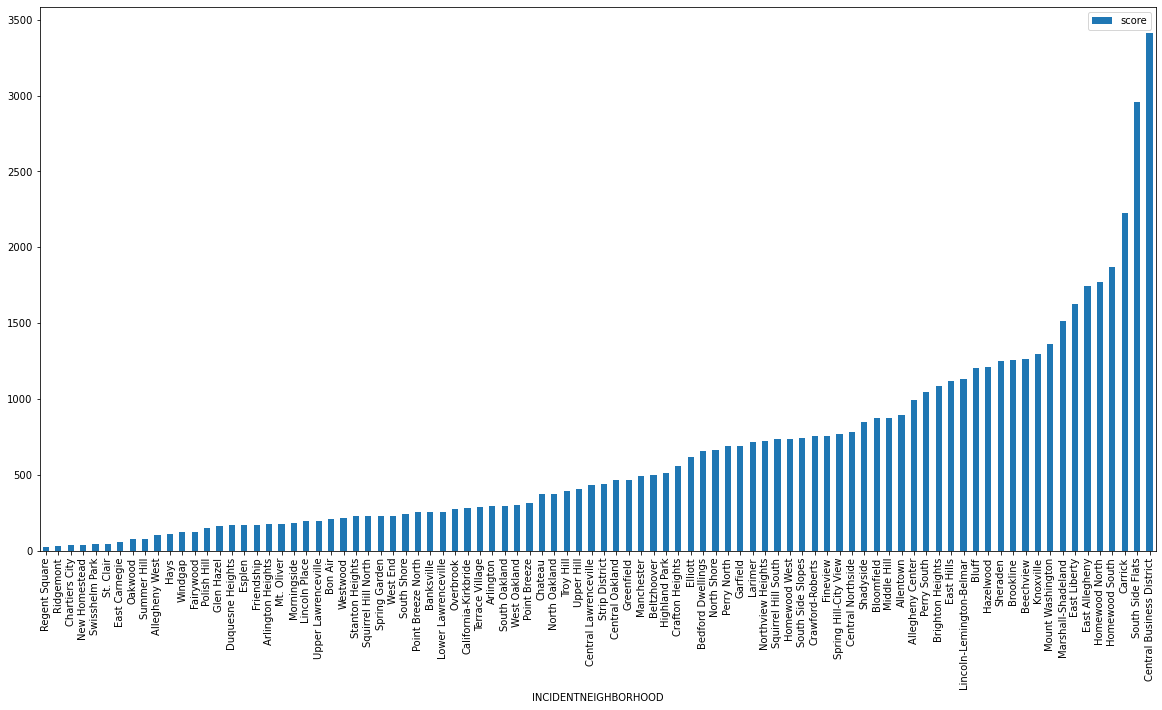

In [8]:
violent_crime_dict = pd.Series(violent_crime['count'].values,index=violent_crime['INCIDENTNEIGHBORHOOD']).to_dict()
crime_score = non_violent_crime


for index, row in crime_score.iterrows():
    if row['INCIDENTNEIGHBORHOOD'] in violent_crime_dict:
        crime_score.at[index, 'count'] += violent_crime_dict[row['INCIDENTNEIGHBORHOOD']] * 2

crime_score = pd.DataFrame.from_dict(crime_score)
crime_score.columns = ['INCIDENTNEIGHBORHOOD', 'score']

# make sure population and crime score neighborhoods match
crime_score = crime_score[~crime_score['INCIDENTNEIGHBORHOOD'].str.contains('|'.join(["Golden Triangle/Civic Arena", "Outside", "Troy Hill-Herrs Island"]), na=False)]


crime_score = crime_score.sort_values('score', ascending = 'True')
crime_score.plot.bar('INCIDENTNEIGHBORHOOD', 'score', figsize=(20,10))

### Accounting for population
Neighborhoods with greater populations will naturally have a higher number of arrests, so we should divide each count by population. In other words, we will create a final metric of "crime score per capita".

In [9]:
population = pd.read_csv("population.csv", parse_dates = True)
population = population[['Neighborhood', 'Population (2010)']]
population.head(10)

,Neighborhood,Population (2010)
0,Allegheny Center,933
1,Allegheny West,462
2,Allentown,2500
3,Arlington,1869
4,Arlington Heights,244
5,Banksville,4144
6,Bedford Dwellings,1202
7,Beechview,7974
8,Beltzhoover,1925
9,Bloomfield,8442


In [12]:
population_dict = pd.Series(population['Population (2010)'].values,index=population['Neighborhood']).to_dict()
crime_score['score'] = crime_score['score'].astype(float)

for index, row in crime_score.iterrows():
    if row['INCIDENTNEIGHBORHOOD'] in population_dict:
        crime_score.at[index, 'score'] /= population_dict[row['INCIDENTNEIGHBORHOOD']]
        
crime_score = crime_score.sort_values('score', ascending = 'True')    
crime_score.head(10)

,INCIDENTNEIGHBORHOOD,score
53,Squirrel Hill North,0.000002
29,Squirrel Hill South,0.000003
43,North Oakland,0.000003
14,Shadyside,0.000004
15,Brookline,0.000007
45,Greenfield,0.000009
67,Stanton Heights,0.000011
54,Point Breeze,0.000011
18,Bloomfield,0.000012
33,Highland Park,0.000012


### Results

<AxesSubplot:xlabel='INCIDENTNEIGHBORHOOD'>

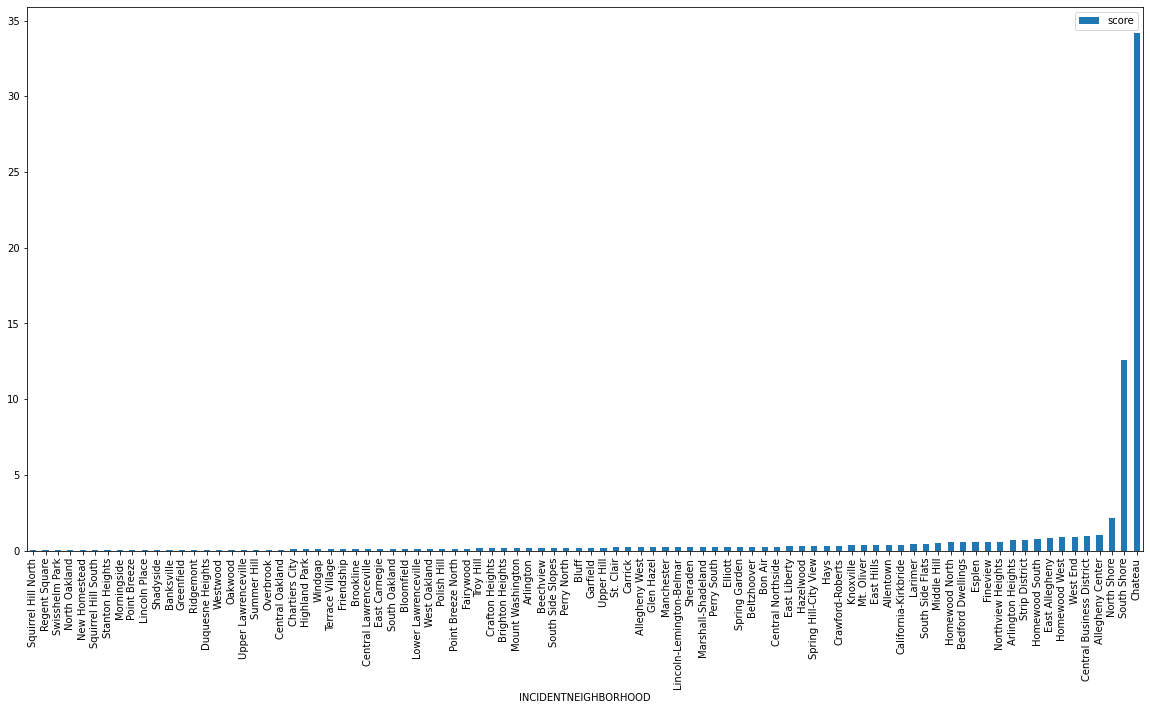

In [11]:
crime_score.plot.bar('INCIDENTNEIGHBORHOOD', 'score', figsize=(20,10))

Looks like Squirrel Hill North is the best scoring neighborhood for this metric, followed by Regent Square and Swisshelm Park.